In [1]:
# # install dependencies: (use cu111 because colab has CUDA 11.1)
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# # install mmcv-full thus we could use CUDA operators
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# # Install mmdetection
# !rm -rf mmdetection
# !git clone https://github.com/open-mmlab/mmdetection.git
# %cd mmdetection

# !pip install -e .
#https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb


In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.0+cu116 True


/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


2.28.1
11.6
GCC 9.3


In [5]:
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O ./checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


--2023-02-15 04:59:24--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.22.207, 163.181.22.212, 163.181.22.208, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.22.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291982 (160M) [application/octet-stream]
Saving to: ‘./checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’

./checkpoint/faster 100%[===================>] 159.54M  35.0MB/s    in 4.9s    

2023-02-15 04:59:29 (32.3 MB/s) - ‘./checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’ saved [167291982/167291982]



In [7]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = '/Gits/MZ/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [9]:
# Use the detector to do inference
img = 'mmdetection/demo/demo.jpg'
result = inference_detector(model, img)

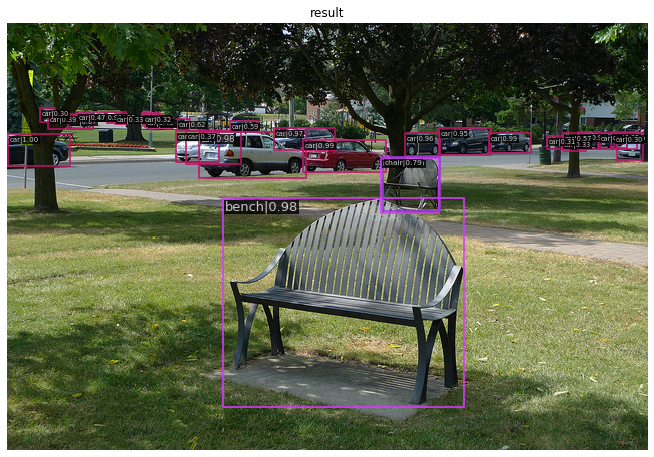

In [10]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

# Train A Detector on A Customized Dataset
To train a new detector, there are usually three things to do:

Support a new dataset
Modify the config
Train a new detector
Support a new dataset
There are three ways to support a new dataset in MMDetection:

Reorganize the dataset into a COCO format.
Reorganize the dataset into a middle format.
Implement a new dataset.
We recommend the first two methods, as they are usually easier than the third one.

In this tutorial, we give an example that converts the data into the formats of existing datasets, e.g. COCO, VOC, etc. Other methods and more advanced usages can be found in the doc.

First, let's download a tiny dataset obtained from KITTI. We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but with 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of the dataset.

In [1]:
# download, decompress the data
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2023-02-16 02:38:59--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.22.213, 163.181.22.211, 163.181.22.212, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.22.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  --.-KB/s    in 0.1s    

2023-02-16 02:38:59 (57.6 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [2]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
kitti_tiny
├── train.txt
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg
│   │   ├── 000005.jpeg
│   │   ├── 000006.jpeg
│   │   ├── 000007.jpeg
│   │   ├── 000008.jpeg
│   │   ├── 000009.jpeg
│   │   ├── 000010.jpeg
│   │   ├── 000011.jpeg
│   │   ├── 000012.jpeg
│   │   ├── 000013.jpeg
│   │   ├── 000014.jpeg
│   │   ├── 000015.jpeg
│   │   ├── 000016.jpeg
│   │   ├── 000017.jpeg
│   │   ├── 000018.jpeg
│   │   ├── 000019.jpeg
│   │   ├── 000020.jpeg
│   │   ├── 000021.jpeg
│   │   ├── 000022.jpeg
│   │   ├── 000023.jpeg
│   │   ├── 000024.jpeg
│   │   ├── 000025.jpeg
│   │   ├── 000026.jpeg
│   │   ├── 000027.jpeg
│   │   ├── 000028.jpeg
│   │   ├── 000029.jpeg
│   │   ├── 000030.jpeg
│   │   ├──

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(

Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


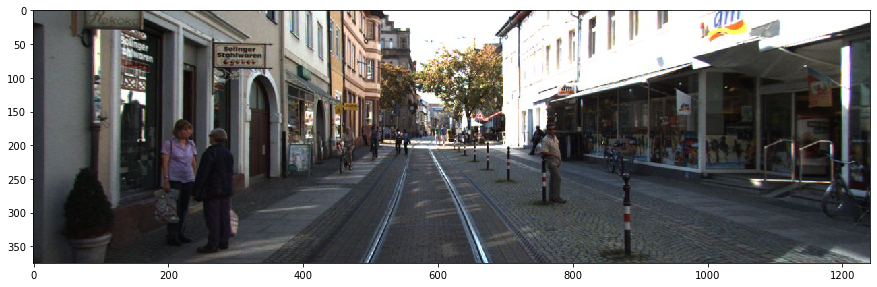

In [3]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [4]:
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


In [5]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

# Modify the config
In the next step, we need to modify the config for the training. To accelerate the process, we finetune a detector using a pre-trained detector.

In [7]:
from mmcv import Config
cfg = Config.fromfile('/Gits/MZ/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [8]:
'''
Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset. We modify the config of datasets, learning rate schedules, and runtime settings.
'''

'\nGiven a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset. We modify the config of datasets, learning rate schedules, and runtime settings.\n'

In [11]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = '/Gits/MZ/checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.device = 'cuda'
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

# Train a new detector
Finally, lets initialize the dataset and detector, then train a new detector! We use the high-level API train_detector implemented by MMDetection. This is also used in our training scripts. For details of the implementation, please see here.

In [12]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2023-02-16 02:43:28,240 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-02-16 02:43:28,402 - mmdet - INFO - load checkpoint from local path: /Gits/MZ/checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
2023-02-16 02:43:28,542 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 21.1 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-02-16 02:44:47,641 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 131  | 0.968  | 0.872 |
| Pedestrian | 13  | 39   | 0.846  | 0.755 |
| Cyclist    | 7   | 47   | 0.429  | 0.135 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.587 |
+------------+-----+------+--------+-------+
2023-02-16 02:44:47,708 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5870, mAP: 0.5872


# Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a pre-trained Faster R-CNN model and fine-tune it for detection. The original Faster R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Faster R-CNN for classification and regression have different weight shape and are not used.

Second, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 58.1 mAP on the val dataset, not bad!

We can also check the tensorboard to see the curves.

In [15]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4232), started 0:00:29 ago. (Use '!kill 4232' to kill it.)

From the tensorboard, we can observe that changes of loss and learning rate. We can see the losses of each branch gradually decrease as the training goes by.

Test the Trained Detector
After finetuning the detector, let's visualize the prediction results!

/opt/conda/lib/python3.8/site-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


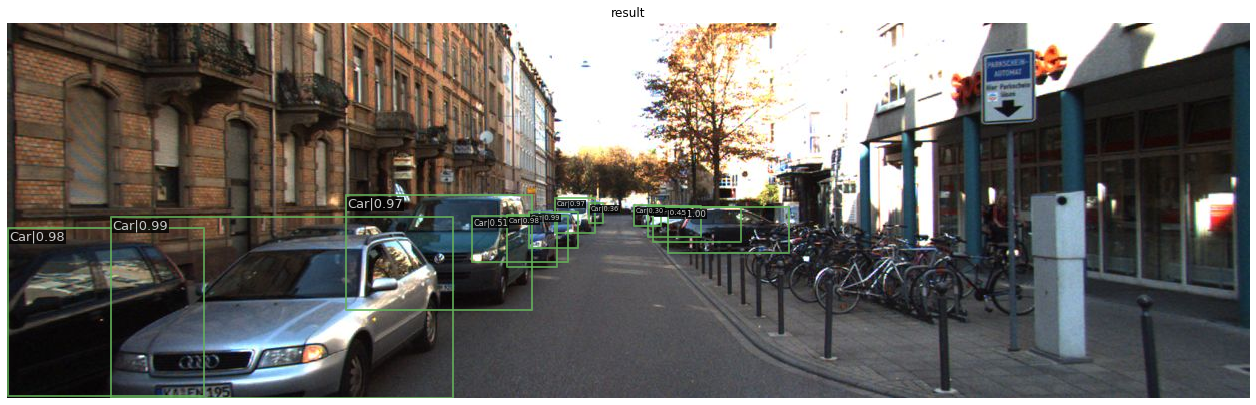

In [17]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

# What to Do Next?
So far, we have learnt how to test and train a two-stage detector using MMDetection. To further explore MMDetection, you could do several other things as shown below:

Try single-stage detectors, e.g., RetinaNet and SSD in MMDetection model zoo. Single-stage detectors are more commonly used than two-stage detectors in industry.
Try anchor-free detectors, e.g., FCOS and RepPoints in MMDetection model zoo. Anchor-free detector is a new trend in the object detection community.
Try 3D object detection using MMDetection3D, also one of the OpenMMLab projects. In MMDetection3D, not only can you try all the methods supported in MMDetection but also some 3D object detectors.